<a href="https://colab.research.google.com/github/bysischpok/Lab1/blob/main/%D0%90%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection Using Autoencoder

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива?

### Автокодировщик

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg?w=638&ssl=1" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции.

Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков (30 признаков).

## Declare required dependencies

1. ID : customer ID
2. Age : age of customer
3. Experience : the number of years that the customer has experience
4. Income : the customer's annual earnings
5. ZIP Code : the postal code of the customer's location

6. Family : the number of people in the customer's family
7. CCAvg : the average monthly credit card spending
8. Education : the level of customer's Education(undergraduate,graduate,professional)
9. Mortgage : the Value of the customer's mortgage(the thing that the customer uses as a guarantee to the bank)
10. Securities Account : whether the customer has a security account or not(it's also known as an investment account)
11. CD Account : the customer has a CD account or not(a type of savings account that lets the customer earn interest on a fixed amount of money for a fixed period)
12. Online : the customer uses the bank's online services or not
13. CreditCard : the customer uses the bank's credit card or not
14. Personal Loan : the customer is granted loans or not

In [419]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ['0','1']

## Data ingestion

In [420]:
df = pd.read_csv('Bank_Loan_Granting.csv')

## Data exploration

In [421]:
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1/60,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1/50,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1/00,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2/70,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1/00,2,0,0,0,0,0,1


In [422]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  5000 non-null   int64 
 1   Age                 5000 non-null   int64 
 2   Experience          5000 non-null   int64 
 3   Income              5000 non-null   int64 
 4   ZIP Code            5000 non-null   int64 
 5   Family              5000 non-null   int64 
 6   CCAvg               5000 non-null   object
 7   Education           5000 non-null   int64 
 8   Mortgage            5000 non-null   int64 
 9   Personal Loan       5000 non-null   int64 
 10  Securities Account  5000 non-null   int64 
 11  CD Account          5000 non-null   int64 
 12  Online              5000 non-null   int64 
 13  CreditCard          5000 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 547.0+ KB


In [423]:
#Удаляем столбцы ID, ZIP Code и CCAvg так как они уникальны и неинформативны для обучения
df = df.drop('ID',axis=1)
df = df.drop('ZIP Code',axis=1)
df = df.drop('CCAvg',axis=1)
print(df.shape)
print(df.describe())

(5000, 11)
               Age   Experience       Income       Family    Education  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     45.338400    20.104600    73.774200     2.396400     1.881000   
std      11.463166    11.467954    46.033729     1.147663     0.839869   
min      23.000000    -3.000000     8.000000     1.000000     1.000000   
25%      35.000000    10.000000    39.000000     1.000000     1.000000   
50%      45.000000    20.000000    64.000000     2.000000     2.000000   
75%      55.000000    30.000000    98.000000     3.000000     3.000000   
max      67.000000    43.000000   224.000000     4.000000     3.000000   

          Mortgage  Personal Loan  Securities Account  CD Account  \
count  5000.000000    5000.000000         5000.000000  5000.00000   
mean     56.498800       0.096000            0.104400     0.06040   
std     101.713802       0.294621            0.305809     0.23825   
min       0.000000       0.000000            0

## Ести ли пропуски?

In [424]:
df.isnull().values.any()
#Пропусков нет

False

## Class distribution ( 0 - не одобрен кредит, 1 - одобрен кредит)

In [425]:
df['Personal Loan'].value_counts()

,count
Personal Loan,
0,4520
1,480


<ipython-input-426-084d4ab974c6>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Personal Loan'], sort = True)


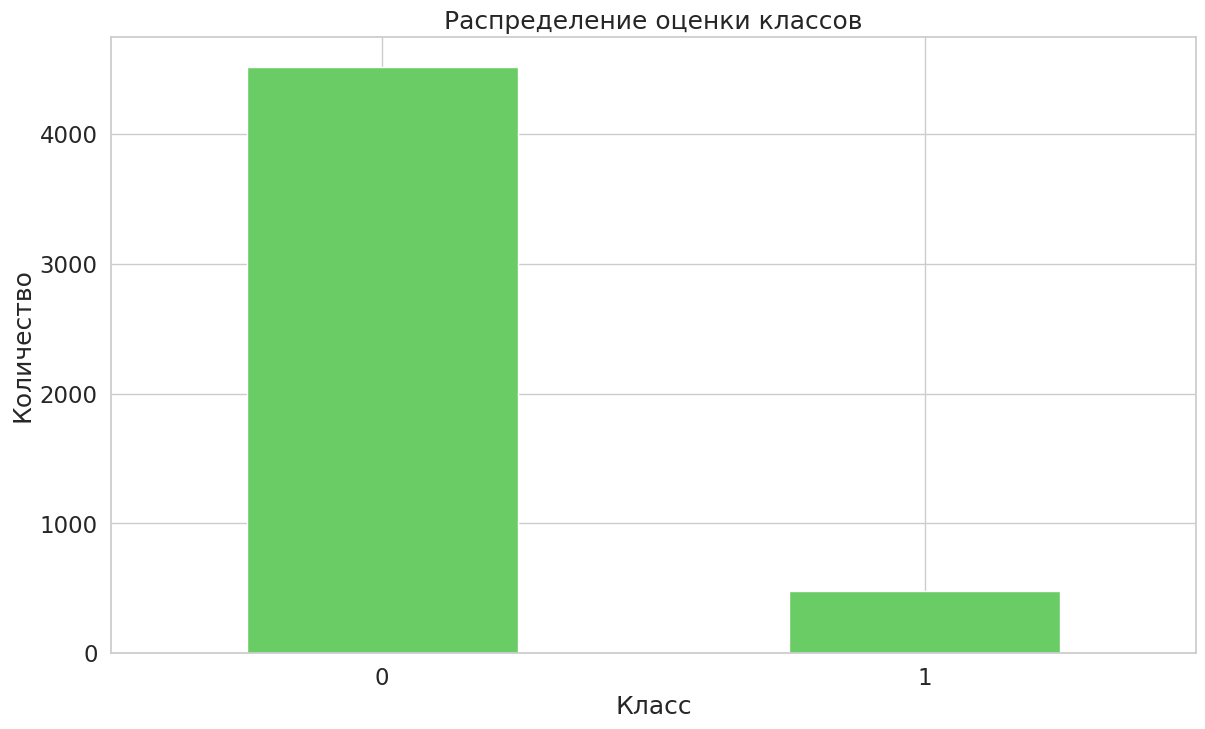

In [426]:
count_classes = pd.value_counts(df['Personal Loan'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Распределение оценки классов")
plt.xticks(range(2), LABELS)
plt.xlabel("Класс")
plt.ylabel("Количество");

Наш набор данных несбалансирован, решим эту проблему с помощью балансирования SMOTE

In [427]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan']

# Split data into training and testing sets (important for evaluating performance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #stratify to maintain class proportions in train/test


# Apply SMOTE to oversample the minority class in the training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#Check class distribution before and after SMOTE
print("Original class distribution (Training):", pd.Series(y_train).value_counts())
print("Class distribution after SMOTE (Training):", pd.Series(y_train_resampled).value_counts())

df = pd.concat([pd.DataFrame(X_train_resampled), pd.DataFrame(y_train_resampled)], axis=1)

Original class distribution (Training): Personal Loan
0    3616
1     384
Name: count, dtype: int64
Class distribution after SMOTE (Training): Personal Loan
0    3616
1    3616
Name: count, dtype: int64


In [428]:
df.shape

(7232, 11)


График расспределения доходов у людей, которым одобрен/не одобрен кредит

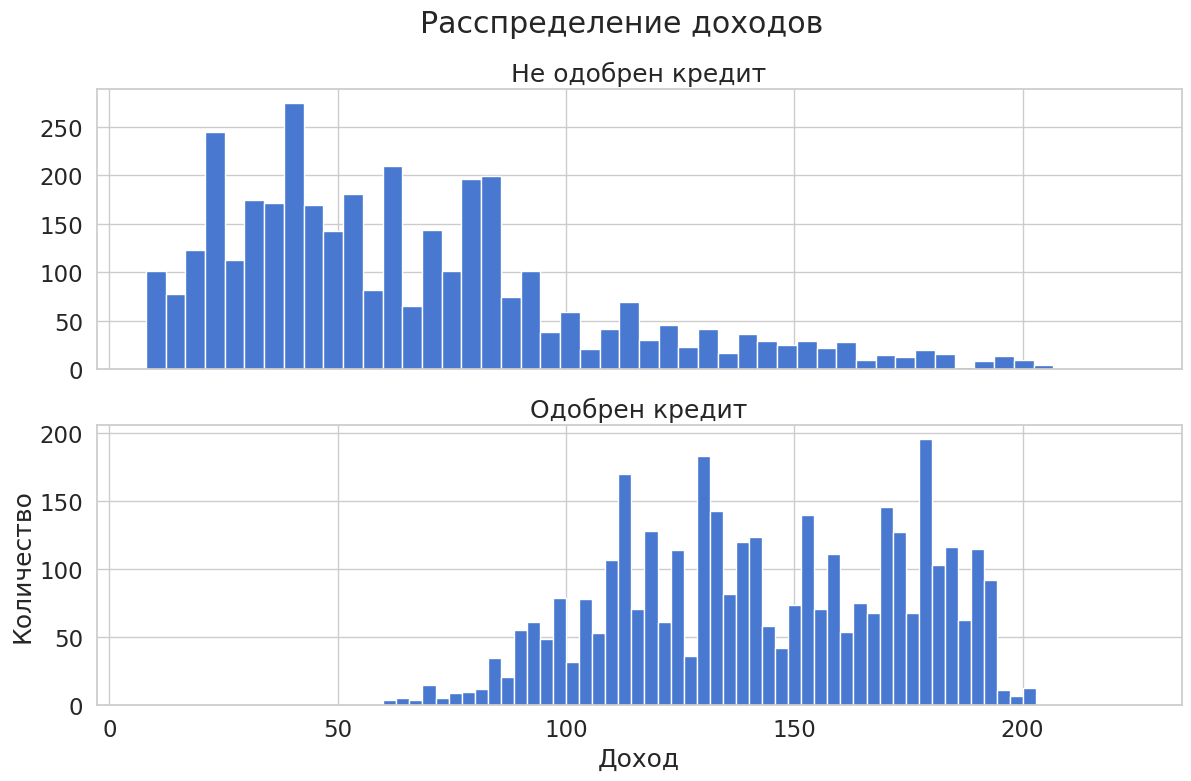

In [429]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Расспределение доходов')

bins = 50

ax1.hist(df[df['Personal Loan']==0]['Income'], bins = bins)
ax1.set_title('Не одобрен кредит')

ax2.hist(df[df['Personal Loan']==1]['Income'], bins = bins)
ax2.set_title('Одобрен кредит')

plt.xlabel('Доход')
plt.ylabel('Количество')
plt.show();

## Preprocessing

Признаки не очень хорошо коррелируют с целевым признаком, кроме дохода. Так же применим StandartScaler ко всем данным кроме целевого столбца.

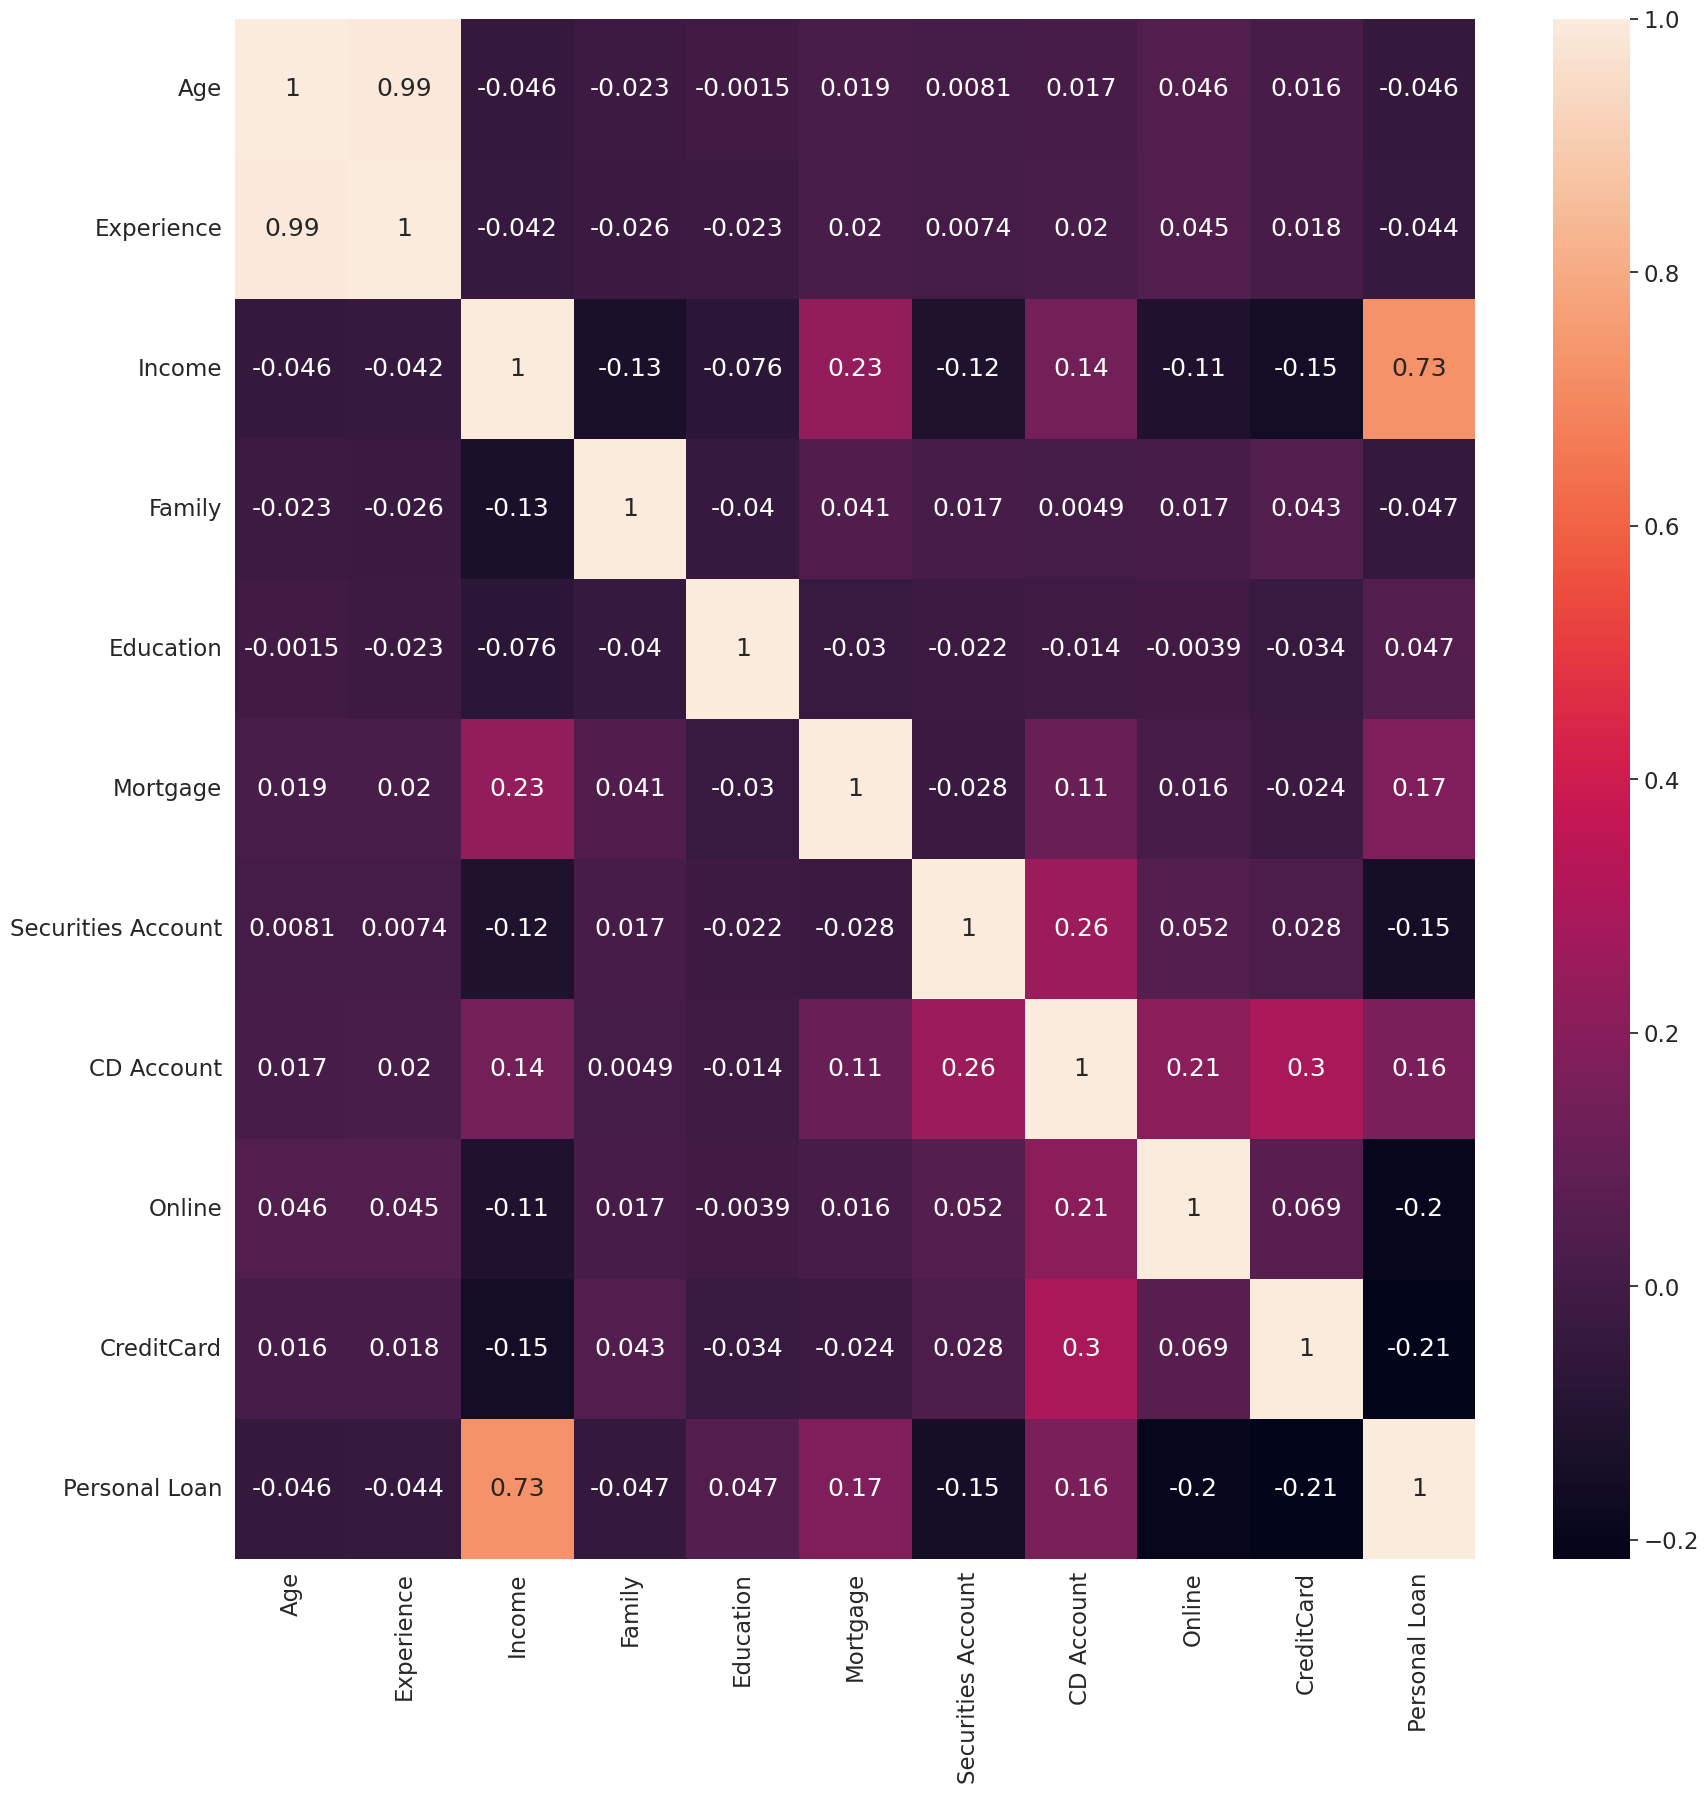

In [430]:
fig = plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(),annot = True)
plt.show()

In [431]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['number']).columns
numeric_cols = numeric_cols.drop('Personal Loan')
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df.head()

,Age,Experience,Income,Family,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,1.338062,1.444744,-0.293532,-0.289750,-1.160878,-0.565448,-0.262739,-0.29167,1.003879,-0.504231,0
1,-0.087351,-0.068844,-1.403354,-1.229424,1.475890,-0.565448,-0.262739,-0.29167,1.003879,-0.504231,0
2,-1.690942,-1.760502,-1.610270,-1.229424,0.157506,0.355498,-0.262739,-0.29167,1.003879,-0.504231,0
3,-0.978235,-0.959190,-1.196439,-0.289750,-1.160878,0.659943,-0.262739,-0.29167,1.003879,1.983217,0
4,0.981709,1.088606,-1.008333,1.589598,-1.160878,-0.565448,-0.262739,-0.29167,-0.996136,-0.504231,0


### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только люди которым не одобрен кредит, а в тестовом наборе данных будут все данные.


In [432]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train['Personal Loan'] == 0]
X_train = X_train.drop(['Personal Loan'], axis=1)

y_test = X_test['Personal Loan']
X_test = X_test.drop(['Personal Loan'], axis=1)

X_train = X_train.values
X_test = X_test.values
y_test = y_test.values

print(y_test.size)
print(X_train.shape)

1447
(2909, 10)


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 8,6,6,10 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер.

In [573]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(10, 8),
            nn.Tanh(),
            nn.Linear(8, 6),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(6, 8),
           nn.Tanh(),
           nn.Linear(8, 10),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [574]:
model = Autoencoder().double()

In [575]:
num_epochs = 100   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 10
learning_rate = 0.001

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шагами мы изменяем градиент.

In [576]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

In [577]:
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [578]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [579]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [580]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), 'model.pth')

epoch [1/100], loss:0.8248
epoch [2/100], loss:0.5882
epoch [3/100], loss:0.4345
epoch [4/100], loss:0.3765
epoch [5/100], loss:0.3289
epoch [6/100], loss:0.2962
epoch [7/100], loss:0.2777
epoch [8/100], loss:0.2653
epoch [9/100], loss:0.2547
epoch [10/100], loss:0.2430
epoch [11/100], loss:0.2286
epoch [12/100], loss:0.2097
epoch [13/100], loss:0.1886
epoch [14/100], loss:0.1697
epoch [15/100], loss:0.1529
epoch [16/100], loss:0.1382
epoch [17/100], loss:0.1269
epoch [18/100], loss:0.1194
epoch [19/100], loss:0.1146
epoch [20/100], loss:0.1112
epoch [21/100], loss:0.1091
epoch [22/100], loss:0.1072
epoch [23/100], loss:0.1058
epoch [24/100], loss:0.1047
epoch [25/100], loss:0.1036
epoch [26/100], loss:0.1029
epoch [27/100], loss:0.1021
epoch [28/100], loss:0.1015
epoch [29/100], loss:0.1007
epoch [30/100], loss:0.1004
epoch [31/100], loss:0.0998
epoch [32/100], loss:0.0991
epoch [33/100], loss:0.0989
epoch [34/100], loss:0.0982
epoch [35/100], loss:0.0978
epoch [36/100], loss:0.0973
e

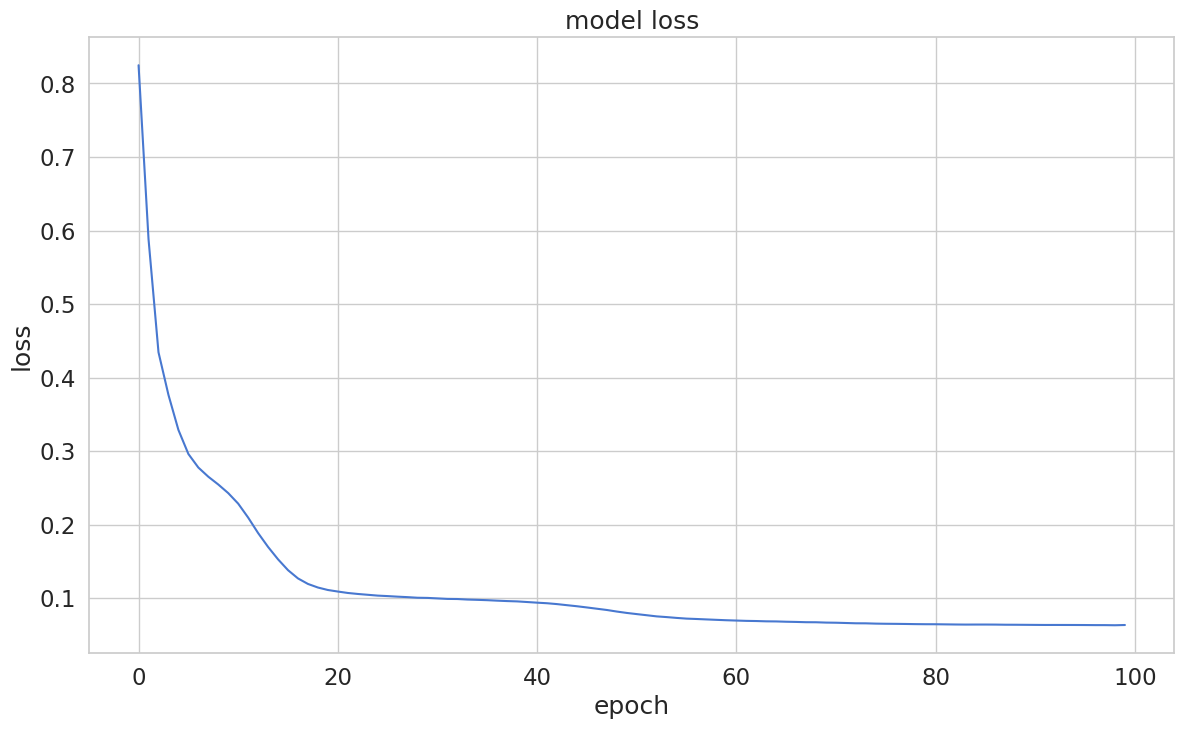

In [581]:
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Оценка модели

In [582]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Personal Loan'] = y_test

In [583]:
reconstructionErrorDF.describe()

,pred_loss,Personal Loan
count,1447.000000,1447.000000
mean,0.271483,0.511403
std,0.412423,0.500043
min,0.000971,0.000000
25%,0.035336,0.000000
50%,0.093382,1.000000
75%,0.339060,1.000000
max,3.226840,1.000000


#Реконструкция ошибок для тех, кому не одобрили кредит

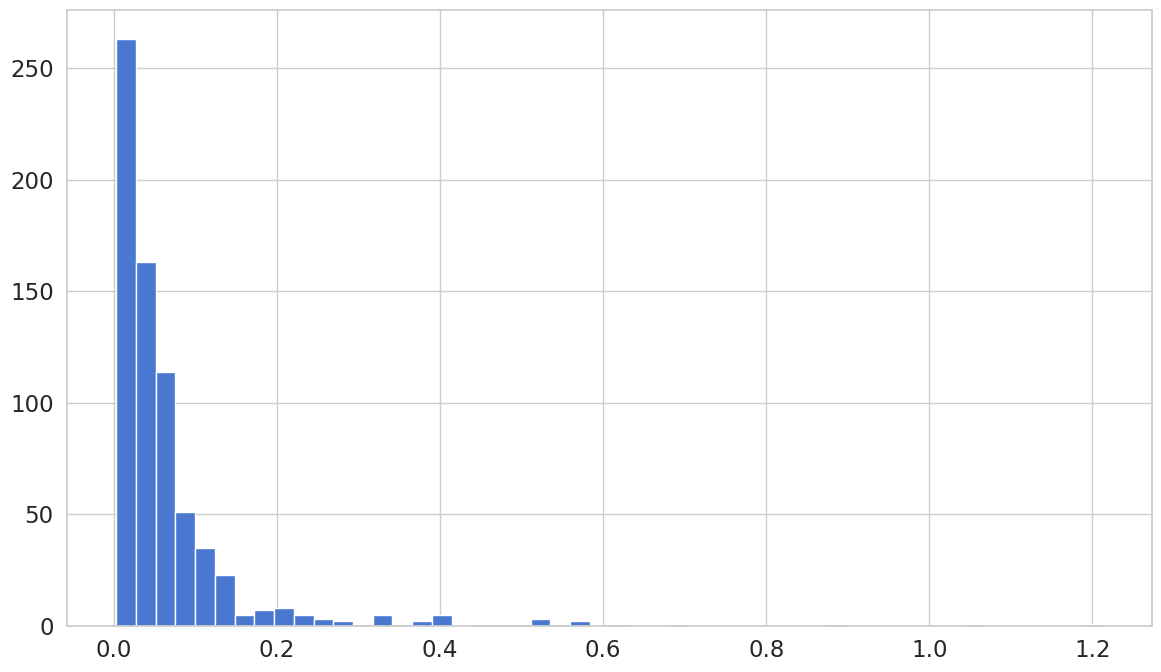

In [587]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Personal Loan']== 0)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=50)

#Реконструкция ошибок для тех, кому одобрили кредит

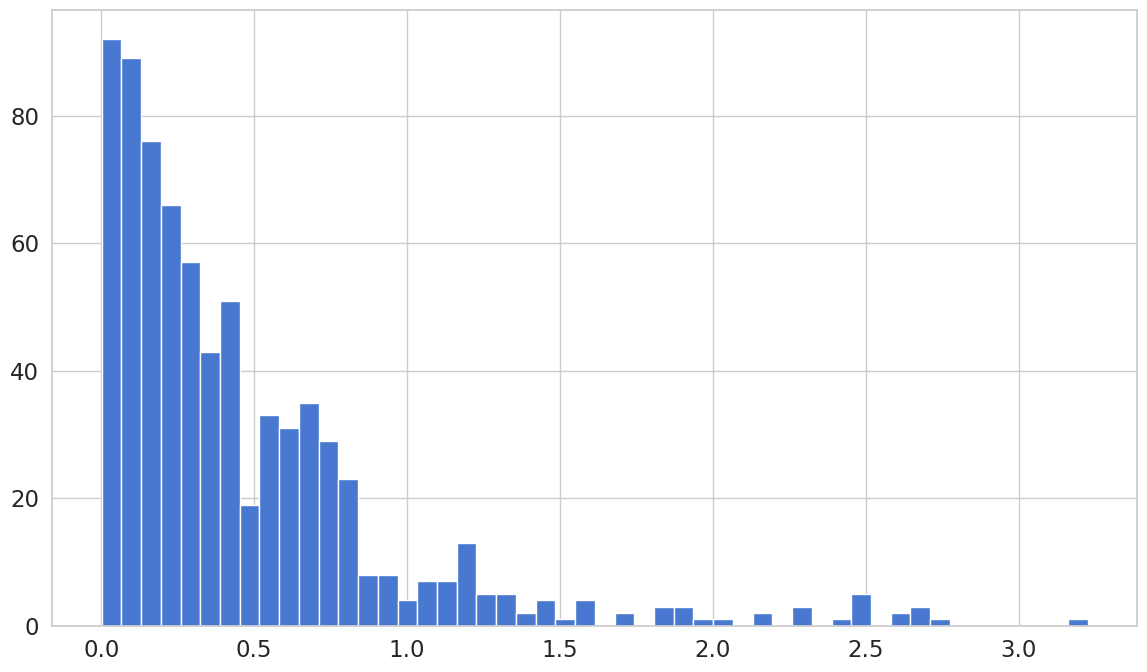

In [586]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Personal Loan']== 1)]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=50)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

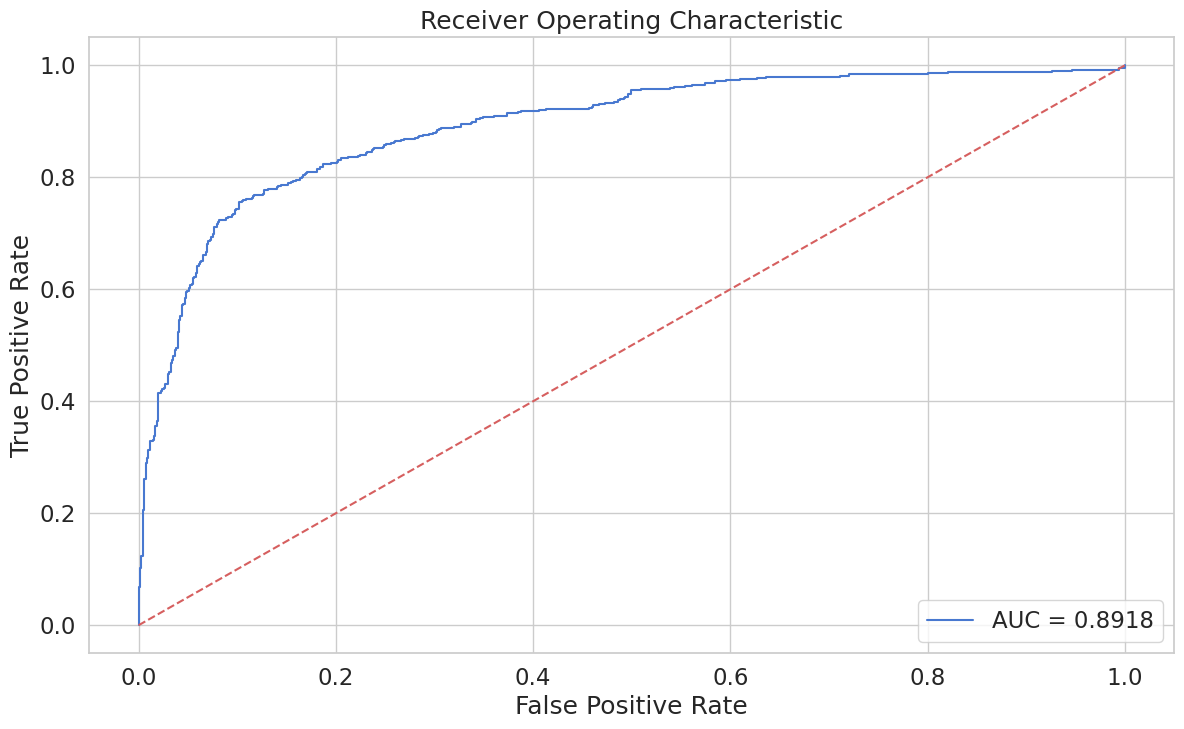

In [588]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF['Personal Loan'], reconstructionErrorDF['pred_loss'])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

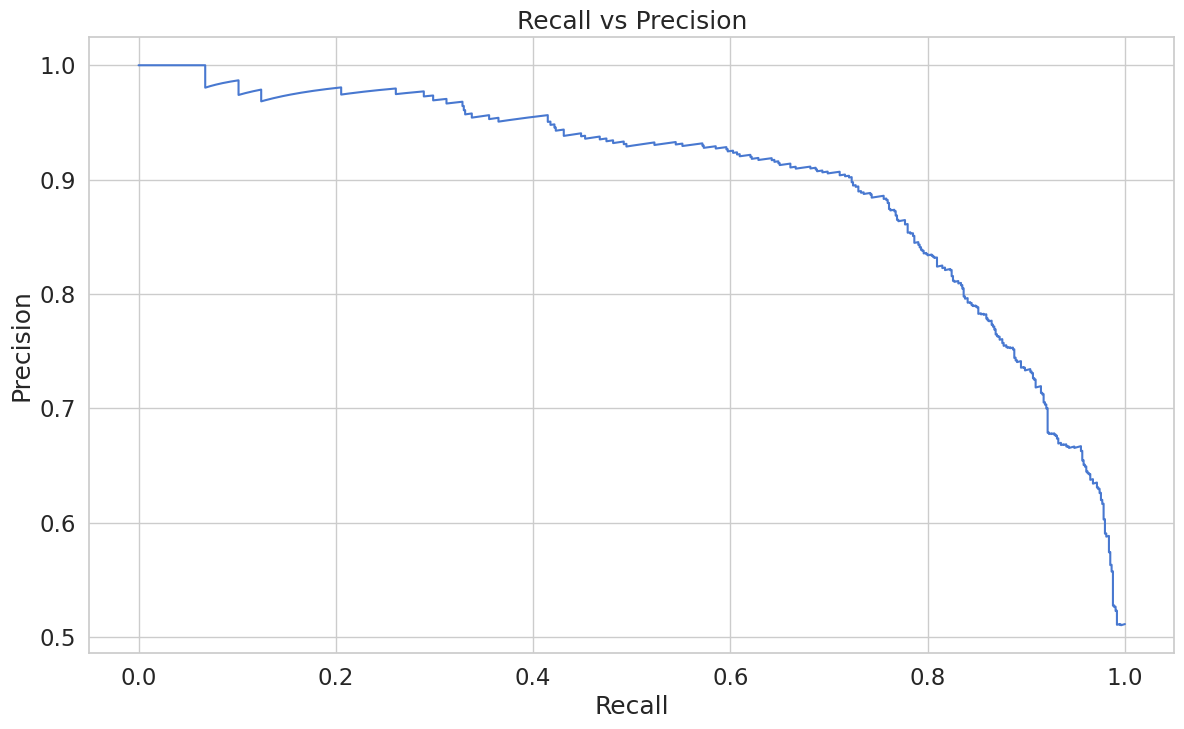

In [589]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF['Personal Loan'], reconstructionErrorDF['pred_loss'])
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

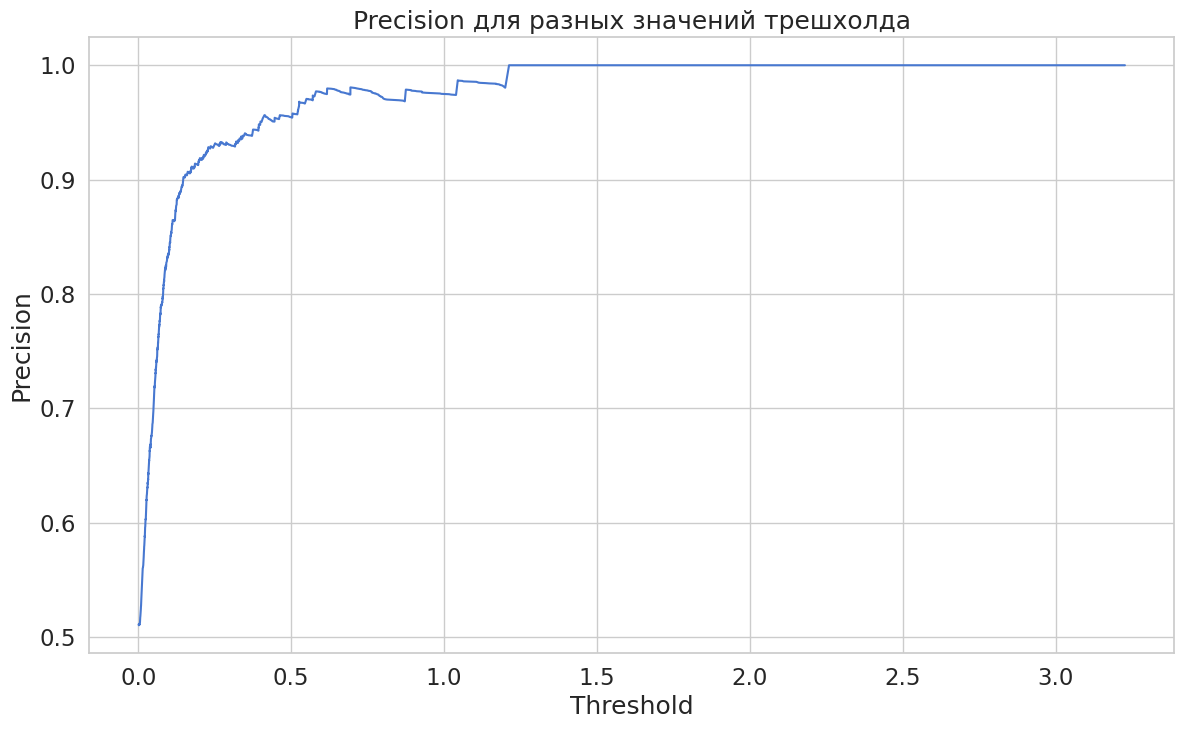

In [590]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


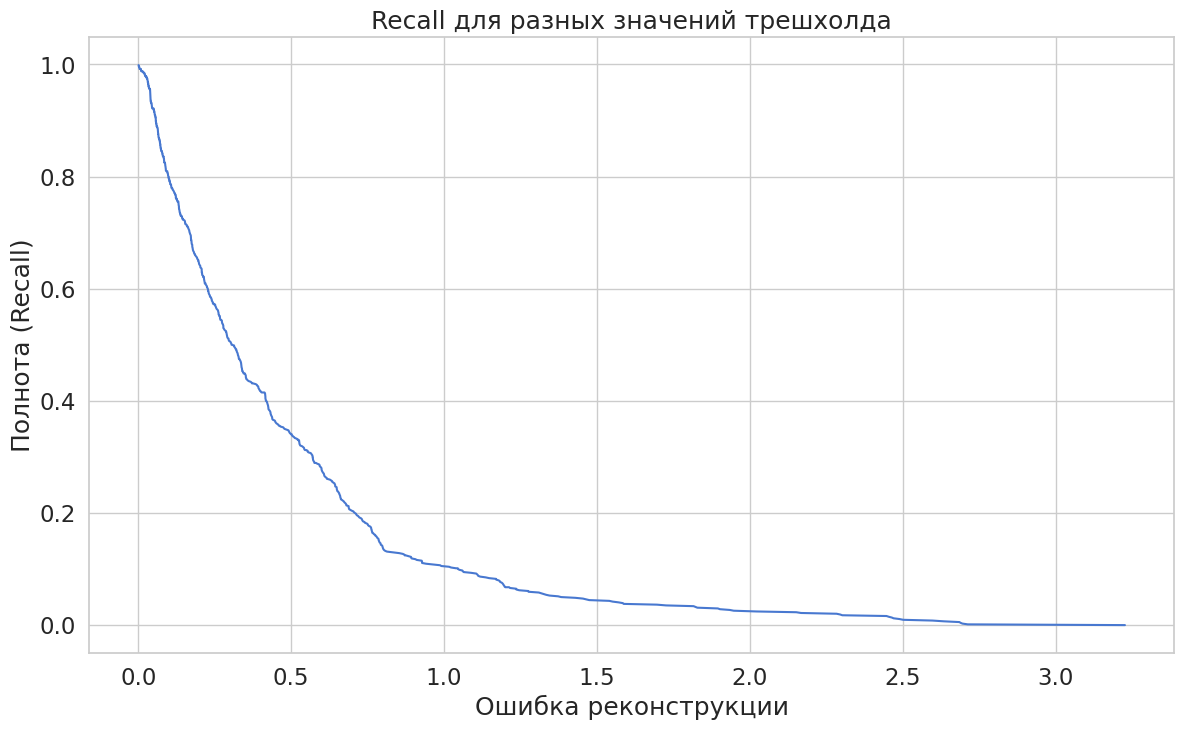

In [591]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, является ли новый клиент человеком, которому можно одобрить кредит, мы должны выбрать некоторый уровень ошибки. Если ошибка превышает этот порог, то мы определяем клиента как человека которому можно выдать кредит. В противном случае определяем его как человека, которому кредит мы не одобрим. Выбираем уровень ошибки:

In [623]:
threshold = 0.1

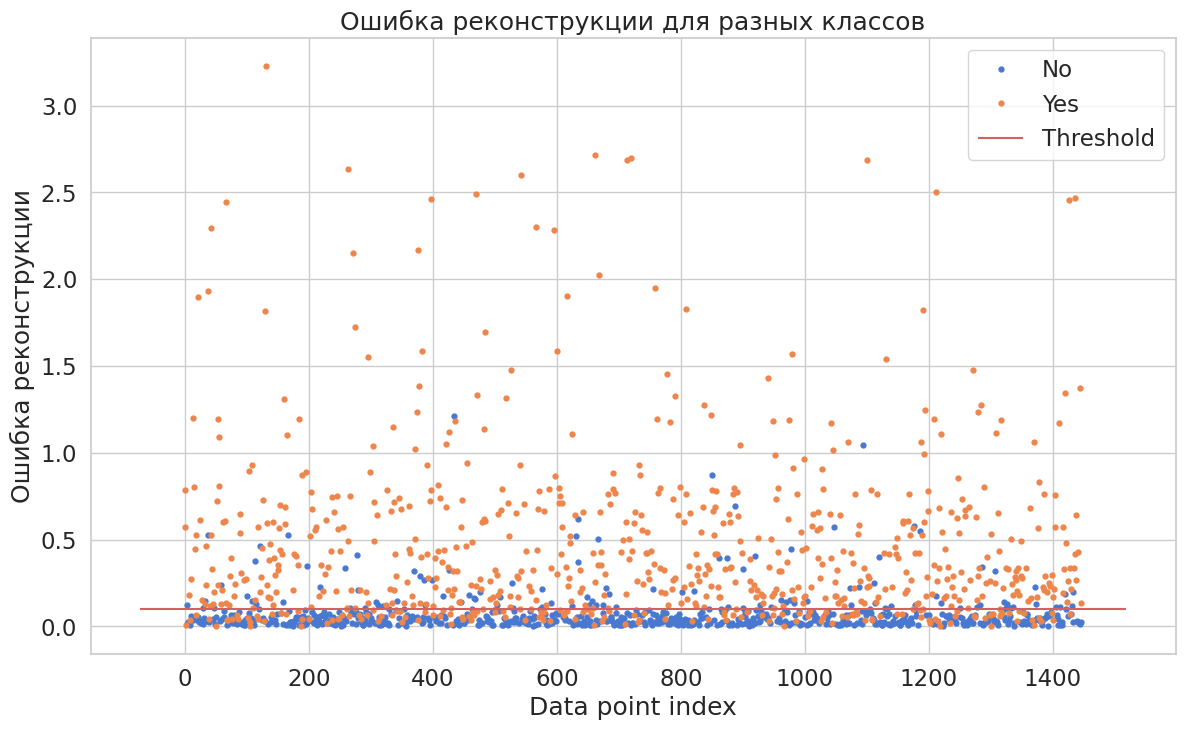

In [624]:
groups = reconstructionErrorDF.groupby('Personal Loan')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Yes" if name == 1 else "No")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-625-38d880888961>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


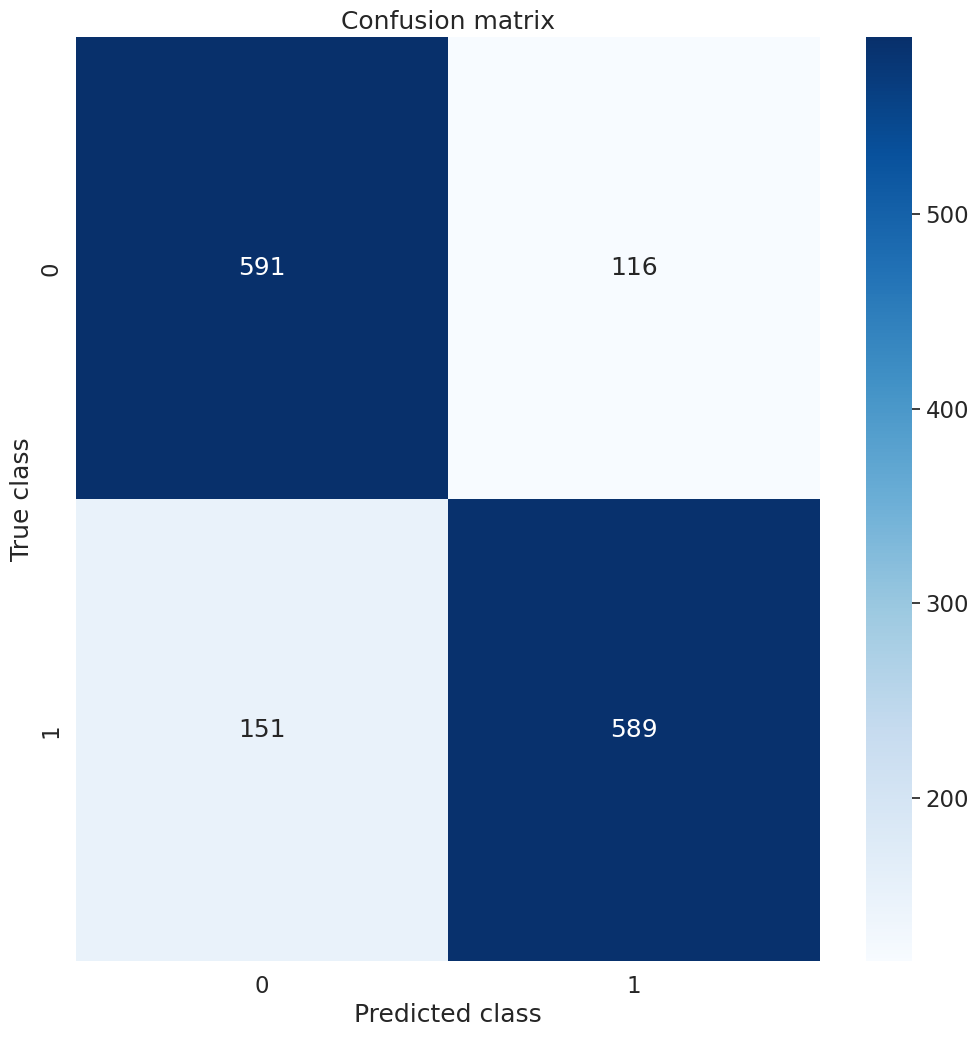

In [625]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF['pred_loss'].values]
conf_matrix = confusion_matrix(reconstructionErrorDF['Personal Loan'], y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [626]:
true_positives = conf_matrix[1, 1]
true_negatives = conf_matrix[0, 0]
false_positives = conf_matrix[0, 1]
false_negatives = conf_matrix[1, 0]

accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8155


## Выводы


Мы создали очень простой Deep Autoencoder в PyTorch, который может реконструировать, как выглядят немошеннические транзакции. Он научился распознавать немошеннические транзакции, изучая некоторые шаблоны, присутствующие в этих транзакциях, и что это за шаблоны, о которых трудно сказать — загадка любой нейронной сети с глубоким обучением.

PyTorch предоставил нам очень понятный и простой в использовании API для создания нетривиального Deep Autoencoder. Можно попытаться создать аналогичный автоэнкодер, используя другую структуру, например Tensorflow/Keras/fast.ai, для другого домена/проблемы, например, классифицировать изображения как содержащие неприемлемый контент.